<a href="https://colab.research.google.com/github/tettey-exploits/TeamFarmNETS/blob/main/crop_disease_detection/FarmNETS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# FarmNETS - Crop Disease Detection for the Sub-Saharan Region

Crop Disease Ghana Dataset: An afrocentric dataset to ensure FarmNETS is effective in the sub-saharan region. Training a model to perform crop disease classification using images from the Sub-Saharan region is crucial for several reasons:

1. **Regional Specificity:** Crop diseases prevalent in the Sub-Saharan region may differ from those found in other parts of the world due to factors such as climate, soil conditions, and agricultural practices. Training a model using locally sourced images ensures that it is tailored to recognize and classify diseases relevant to farmers in the region accurately.

2. **Local Context:** Local farmers in the Sub-Saharan region may face unique challenges and constraints related to agricultural production, including limited access to resources, extension services, and technical expertise. A model trained on images from the region can take into account these contextual factors and provide recommendations that are practical and feasible within the local context.

3. **Empowering Local Communities:** Developing expertise and capabilities in crop disease classification within the Sub-Saharan region empowers local researchers, agricultural experts, and farmers to take ownership of addressing agricultural challenges. It promotes knowledge sharing, capacity building, and innovation within the region, fostering sustainable and self-reliant agricultural systems.

4. **Resilience to Climate Change:** The Sub-Saharan region is particularly vulnerable to the impacts of climate change, which can exacerbate the spread of crop diseases and pests. A robust crop disease classification model trained on region-specific data can help farmers anticipate and respond to changing disease patterns, enhancing resilience to climate-related challenges.

In summary, training a model to perform crop disease classification using images from the Sub-Saharan region is essential for ensuring accurate, contextually relevant, and effective disease management strategies that support the livelihoods and food security of local farmers.







### Import Libraries

In [1]:
# Import required libraries
import zipfile
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import numpy as np
import random
from google.colab import drive
import shutil
from google.colab import files
import pandas as pd
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import files
import time
from sklearn.utils import compute_class_weight
import glob
tf.__version__ # expected: 2.15.0

'2.15.0'

Visit this [link](https://drive.google.com/drive/folders/1-HEpV-W7tWEzht9rQdDHXQO36YZRr_d0?usp=sharing), and create a shortcut of the folder on your drive

In [2]:
drive.mount('/content/drive')
saved_tfdataset_path = "/content/drive/MyDrive/AgricDis_Project/rail_crop_disease_dataset/saved_tfdataset_crop_disease_ghana_agridis/"

Mounted at /content/drive


In [3]:
def check_directories(path_l, del_unwanted_dir=True):
  for dirpath, dirnames, filenames in os.walk(path_l):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

## Dataset Preparation
Crop disease dataset from RAIL. Dataset consists of images of 18 diseases across 3 crops. Images were taken in Ghana


1.   Tomato
2.   Pepper
3.   Maize

Dataset is publicly available on kaggle as [Crop Disease Ghana](https://www.kaggle.com/datasets/responsibleailab/crop-disease-ghana)



### Load dataset
  Images have been preprocessed as below


*   Input Normalization. Pixel values should range from 0 t0 1
*   Resize Input Image to 256 * 256 or 224 * 224
* Shuffle the data




In [4]:
train_data = tf.data.Dataset.load(f"{saved_tfdataset_path}/input_256/train")
valid_data = tf.data.Dataset.load(f"{saved_tfdataset_path}/input_256/valid")
test_data = tf.data.Dataset.load(f"{saved_tfdataset_path}/input_256/test")
class_names = ['Corn__Northern_Leaf_Blight', 'Corn__Cercospora_Leaf_Spot', 'Corn__Common_Rust', 'Corn__Healthy', 'Corn__Streak', 'Tomato__Fosarium', 'Tomato__Septoria', 'Tomato__Early_Blight', 'Tomato__Leaf_curl', 'Tomato__Healthy', 'Tomato__Late_Blight', 'Tomato__Mosaic', 'Pepper__Leaf_Blight', 'Pepper__Cercospora_Leaf_Spot', 'Pepper__Leaf_Curl', 'Pepper__Septoria', 'Pepper__Mosaic', 'Pepper__Fusarium', 'Pepper__Healthy']

## Data Visualization

> Sample Images from the Preprocessed Dataset




In [5]:
def view_sample_preprocessed_images(num_samples=9):
  plt.figure(figsize=(10, 10))
  for images, labels in train_data.take(1):
    for i in range(num_samples):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("float64"))
      plt.title(np.array(class_names)[tf.argmax(labels[i])])
      plt.axis("off")

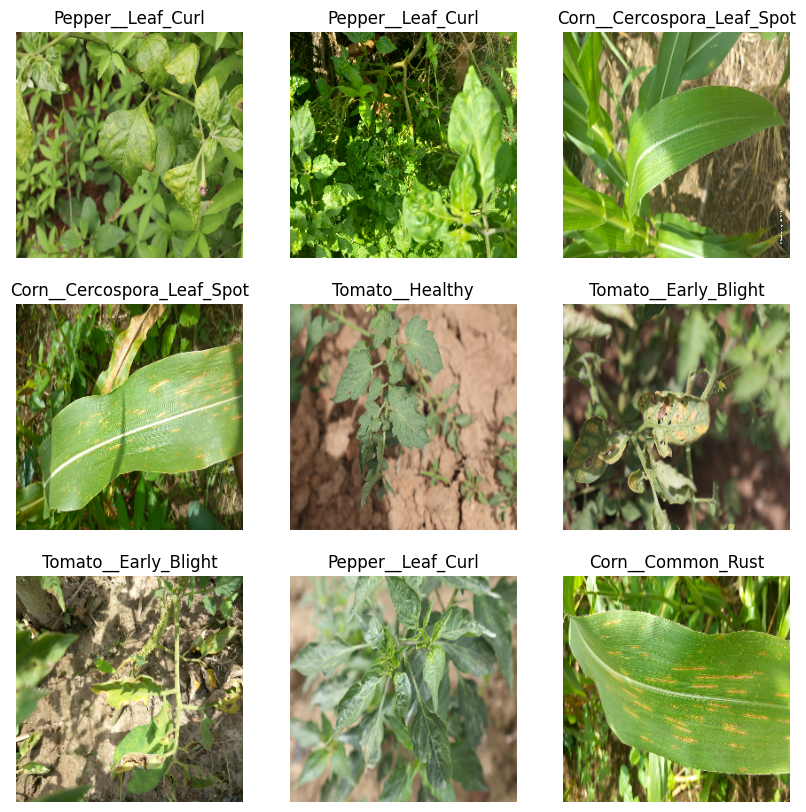

In [6]:
view_sample_preprocessed_images(9)

## AI Model Preparation







### Compile a new model architecture

> ResNet9 Architecture.



#### ResNet9 Model Architecture

In [7]:
# my own code replication

def conv_block(input_layer, num_filters, kernel_size=(3,3), padding="same", apply_pooling=False):
  x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding=padding)(input_layer)
  # x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)

  if apply_pooling:
    x = tf.keras.layers.MaxPool2D(pool_size=(4, 4))(x)

  return x

def residual_block(input_layer, num_filters, kernel_size=(3,3), padding="same", apply_pooling=False):
  y = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding=padding)(input_layer)
  # y = tf.keras.layers.BatchNormalization()(y)
  y = tf.keras.layers.ReLU()(y)

  y = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding=padding)(y)
  # y = tf.keras.layers.BatchNormalization()(y)
  y = tf.keras.layers.ReLU()(y)

  y = tf.keras.layers.add([y, input_layer])

  return y


def resnet9_model(input_layer, num_disease):

  conv_layer_1 = conv_block(input_layer, 64)
  conv_layer_2 = conv_block(conv_layer_1, 128, apply_pooling=True)
  resnet_layer_1 = residual_block(conv_layer_2, num_filters=128)

  conv_layer_3 = conv_block(resnet_layer_1, 256, apply_pooling=True)
  conv_layer_4 = conv_block(conv_layer_3, 512, apply_pooling=True)
  resnet_layer_2 = residual_block(conv_layer_4, num_filters=512)

  maxpool_layer_1 = tf.keras.layers.MaxPool2D(pool_size=(4, 4))(resnet_layer_2)
  flatten_layer = tf.keras.layers.Flatten()(maxpool_layer_1)
  classifier_output = tf.keras.layers.Dense(num_disease, activation="softmax")(flatten_layer)

  return classifier_output

input_layer = tf.keras.Input(shape=(256, 256, 3))
model_output = resnet9_model(input_layer, 19)
resnet_model = tf.keras.models.Model(inputs=input_layer, outputs=model_output)
# resnet_model.summary()

In [8]:
# Compile model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# fit the model
EPOCHS = 30
training_history = resnet_model.fit(train_data,
                                    epochs=EPOCHS,
                                    validation_data=valid_data)

In [ ]:
# evaluate model performance
resnet_model.evaluate(valid_data)

In [ ]:
# Convert the model to tflite.
converter = tf.lite.TFLiteConverter.from_keras_model(resnet_model)
tflite_model = converter.convert()

# Save the model.
with open('resnet_model.tflite', 'wb') as f:
  f.write(tflite_model)